<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Импортируем библиотеки
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

RANDOM_STATE = 180723
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score,\
recall_score, roc_curve, RocCurveDisplay, f1_score, roc_auc_score, r2_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# импорт библиотек Nikolay K
from lightgbm import LGBMClassifier
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)

In [ ]:
pip install fastparquet

In [ ]:
pip install shap

In [6]:
# Make corr function
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

# Dooing downsample function
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

# Doing function for marking cat_features
cat = ['ctg', 'flg','channel_name','src_id']
def cat_columns(columns, cat):
    cat_columns = []
    for col in columns:
        for c in cat:
            if c in col:
                cat_columns.append(col)
    return cat_columns

In [92]:
# Обработка выборки функциями upsample и downsample
# Функция upsample, downsample
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [7]:
#import json
with open('features_types.json') as f:
    data = json.load(f)
print(data)

{'markers_0_1_cnt': 'numeric', 'markers_1_1_cnt': 'numeric', 'markers_2_1_cnt': 'numeric', 'markers_3_1_cnt': 'numeric', 'markers_4_1_cnt': 'numeric', 'markers_5_1_cnt': 'numeric', 'markers_6_1_cnt': 'numeric', 'markers_7_1_cnt': 'numeric', 'markers_8_1_cnt': 'numeric', 'markers_9_1_cnt': 'numeric', 'markers_10_1_cnt': 'numeric', 'markers_11_1_cnt': 'numeric', 'markers_12_1_cnt': 'numeric', 'markers_13_1_cnt': 'numeric', 'markers_14_1_cnt': 'numeric', 'markers_15_1_cnt': 'numeric', 'markers_16_1_cnt': 'numeric', 'markers_17_1_cnt': 'numeric', 'markers_18_1_cnt': 'numeric', 'markers_19_1_cnt': 'numeric', 'markers_20_1_cnt': 'numeric', 'markers_21_1_cnt': 'numeric', 'markers_22_1_cnt': 'numeric', 'markers_23_1_cnt': 'numeric', 'markers_24_1_cnt': 'numeric', 'markers_25_1_cnt': 'numeric', 'markers_26_1_cnt': 'numeric', 'markers_27_1_cnt': 'numeric', 'markers_28_1_cnt': 'numeric', 'markers_29_1_cnt': 'numeric', 'markers_30_1_cnt': 'numeric', 'markers_31_1_cnt': 'numeric', 'markers_32_1_cnt

In [8]:
# Table with name of fields
df1=pd.DataFrame.from_dict(data,orient='index')
df = df1.index
print(df1)

                         0
markers_0_1_cnt    numeric
markers_1_1_cnt    numeric
markers_2_1_cnt    numeric
markers_3_1_cnt    numeric
markers_4_1_cnt    numeric
...                    ...
markers_941_1_cnt  numeric
markers_942_1_cnt  numeric
markers_943_1_cnt  numeric
markers_944_1_cnt  numeric
markers_945_1_cnt  numeric

[2776 rows x 1 columns]


In [9]:
# Сформируем списко признаков
b = df[900:1800].tolist()
c = ['tariff_plans_4_1_num',
 'charges_details_12_1_sum',
 'payments_details_35_6_sum',
 'spas_symptoms_agr_7_6_sum',
 'markers_706_1_cnt',
 'payments_details_28_3_sumpct',
 'payments_details_27_1_sumpct',
 'payments_details_29_6_sumpct',
 'balance_details_0_1_num',
 'payments_details_49_6_avg',
 'payments_details_48_3_sum',
 'markers_346_1_cnt',
 'spas_symptoms_agr_18_6_std',
 'arpu_2_6_avg',
 'markers_349_1_cnt',
 'markers_323_1_cnt',
 'markers_476_1_cnt',
 'payments_details_23_3d6_avg',
 'markers_40_1_cnt',
 'markers_310_1_cnt',
 'markers_60_1_cnt',
 'markers_330_1_cnt',
 'markers_333_1_cnt',
 'payments_details_33_1_sum',
 'markers_334_1_cnt',
 'markers_772_1_cnt',
 'markers_59_1_cnt',
 'markers_242_1_cnt',
 'markers_387_1_cnt',
 'tariff_plans_5_1_num']
a = ['channel_name', 'target',
 'materials_details_16_1_ctg',
 'basic_info_2_0_min',
 'basic_info_0_0_avg',
 'user_devices_30_1_cnt',
 'basic_info_1_0_max',
 'cities_2_0_ctg',
 'user_active_9_1_flg',
 'user_devices_24_1_cnt',
 'type_av_100_0_1_ctg',
 'info_house_10_0_ctg',
 'communication_availability_51_1_flg',
 'materials_details_15_1_ctg',
 'markers_904_1_cnt',
 'movix_app_visits_17_1_cnt',
 'campaigns_369_6_part',
 'markers_933_1_cnt',
 'user_active_23_0_dt',
 'campaigns_357_1_sum',
 'migrant_0_1_flg',
 'markers_925_1_cnt',
 'campaigns_41_6_part',
 'materials_details_21_1_num',
 'campaigns_315_1_sum',
 'agreement_type_0_0_ctg',
 'save_team_answers_21_1_cnt',
 'campaigns_359_1_sum',
 'campaigns_328_1_sum',
 'campaigns_281_1_part',
 'communication_availability_53_1_flg',
 'cities_1_0_ctg',
 'issues_11_6_sum',
 'markers_905_1_cnt',
 'materials_details_22_1_flg',
 'markers_895_1_cnt',
 'user_active_29_1_flg',
 'markers_807_1_cnt',
 'movix_app_visits_62_1_cnt',
 'social_dem_2_0_flg',
 'markers_858_1_cnt',
 'campaigns_40_3_part',
 'campaigns_364_1d6_part',
 'movix_app_visits_24_1_cnt',
 'campaigns_403_3d6_part',
 'user_active_27_0_dt',
 'spas_symptoms_agr_286_12_sum',
 'user_active_10_1_flg',
 'campaigns_324_1_part',
 'user_active_24_0_dt',
 'materials_details_19_1_dt']
features_all = [a + b+ c][0]

In [10]:
features_best = ['id','target','channel_name',
 'basic_info_2_0_min',
  'markers_706_1_cnt',
 'tariff_plans_22_1_min',
 'spas_symptoms_agr_105_12_std',
 'arpu_2_6_avg',
 'user_devices_30_1_cnt',
 'materials_details_15_1_ctg',
 'spas_symptoms_agr_114_6_std',
 'info_house_10_0_ctg',
 'user_active_24_0_dt',
 'user_lifetime_3_0_dt',
 'markers_772_1_cnt',
 'type_av_100_0_1_ctg',
 'traffic_details_43_1_std',
 'markers_476_1_cnt']

In [11]:
features_all  = ['channel_name','target'] + df[1800:].tolist()

In [12]:
len(features_all)

978

In [13]:
# Загрузим признаки
data_all = pd.read_parquet('dataset_train.parquet', engine='fastparquet', columns=features_all)

In [14]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 978 entries, channel_name to markers_945_1_cnt
dtypes: float64(897), int32(56), int64(18), int8(6), object(1)
memory usage: 4.9+ GB


In [15]:
# Marking cat_features
cat = ['ctg', 'flg','channel_name','src_id']
cat_features = cat_columns(data_all, cat)
data_all[cat_features] = data_all[cat_features].astype('category')
#data_all['materials_details_16_1_ctg'] = data_all['materials_details_16_1_ctg'].astype('float64')
#data_all['tariff_plans_20_1_ctg'] = data_all['tariff_plans_20_1_ctg'].astype('float64')

In [16]:
# Make downsampling
features = data_all.drop(['target'], axis=1)
target = data_all['target']
features_downsampled, target_downsampled = downsample(features, target, 0.2)

In [17]:
# Make train and test samples
features_downsampled_train, features_downsampled_test, target_downsampled_train,target_downsampled_test = train_test_split(features_downsampled, target_downsampled, test_size=0.25, random_state=RANDOM_STATE)

In [18]:
print(features_downsampled_train.shape)
print(target_downsampled_train.shape)
print(features_downsampled_test.shape)
print(target_downsampled_test.shape)

(108594, 977)
(108594,)
(36198, 977)
(36198,)


In [13]:
def check_corr_kendall(data: pd.DataFrame):
    """
    Функция для расчета корреляции Пирсона всех признаков с целевой переменной.
    ---
    Принимает на вход pd.DataFrame.
    Возвращает pd.Series с значением коэффициента корреляции для каждого признака.
    """
    # чекаем корреляцию с таргетом
    correlation = data.iloc[:, :-1].corrwith(data['target'], method='kendall')
    
    # сортируем
    correlation = correlation.sort_values(ascending=False)
    
    return correlation

In [ ]:
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 1000)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', 1000)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', 1000)

In [ ]:
check_corr_kendall(data_all)

In [19]:
from lightgbm import LGBMClassifier
cat_features = features_downsampled_train.select_dtypes(include='category').columns.to_list()
lgb = LGBMClassifier(learning_rate=0.05, n_estimators=100, num_leaves=31, is_unbalance=True)
lgb.fit(features_downsampled_train, 
        target_downsampled_train,
        categorical_feature=cat_features)


C:\Users\ipd08\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ipd08\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 4125, number of negative: 104469
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30694
[LightGBM] [Info] Number of data points in the train set: 108594, number of used features: 962
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037986 -> initscore=-3.231824
[LightGBM] [Info] Start training from score -3.231824


LGBMClassifier(is_unbalance=True, learning_rate=0.05)

In [25]:
probabilities_cat = lgb.predict_proba(features_downsampled_test)[:,1]
auc_roc = roc_auc_score(target_downsampled_test, probabilities_cat)

print('Метрика ROC_AUC на тестовой выборке:', auc_roc)

Метрика ROC_AUC на тестовой выборке: 0.7227352893157033


In [26]:
probabilities_cat = lgb.predict(features_downsampled_test)
auc_roc = roc_auc_score(target_downsampled_test, probabilities_cat)

print('Метрика ROC_AUC на тестовой выборке:', auc_roc)

Метрика ROC_AUC на тестовой выборке: 0.6652507475059227


In [16]:
pip install shap

     -------------------------------------- 462.3/462.3 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


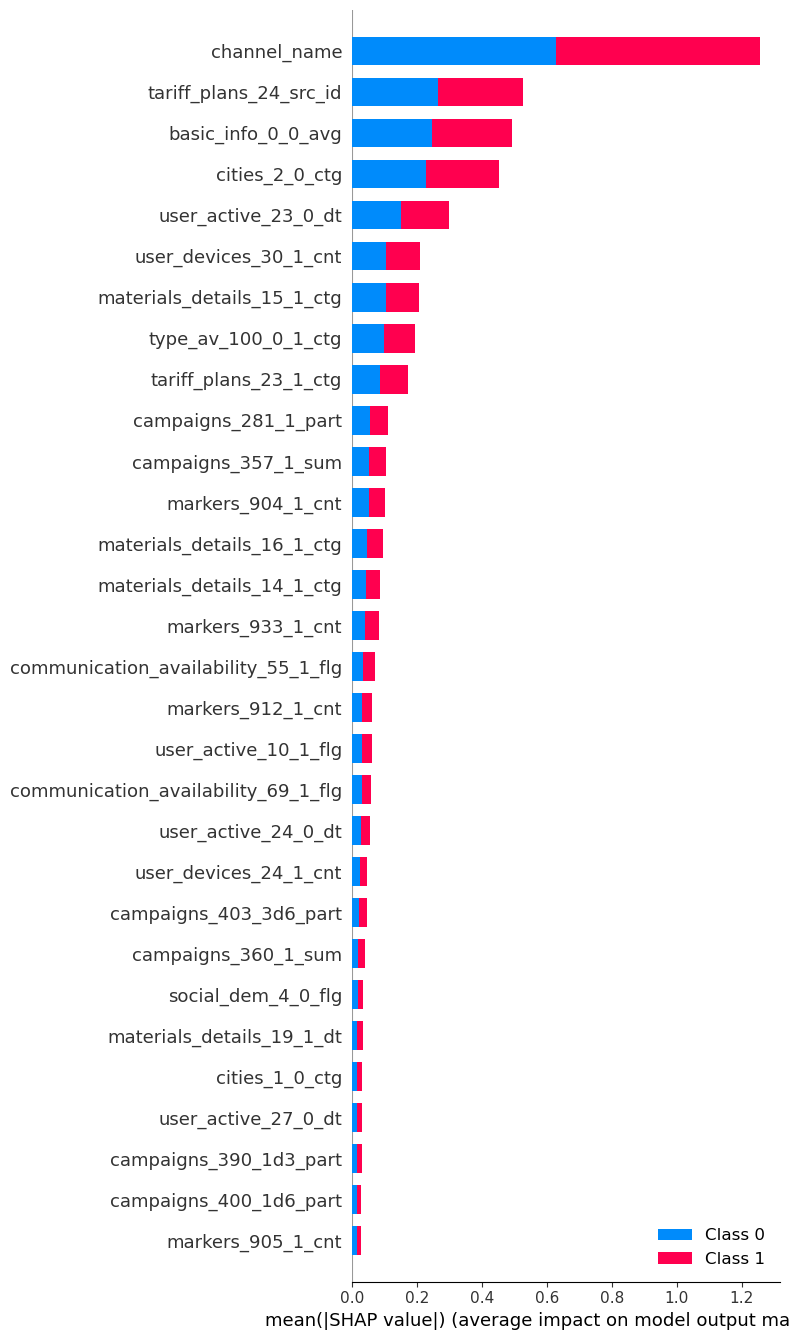

In [22]:
# Отобразим гистограмму важности признаков
import shap
shap_test = shap.TreeExplainer(lgb).shap_values(features_downsampled_train)
shap.summary_plot(shap_test, features_downsampled_train,
                      max_display=30, auto_size_plot=True)

In [27]:
# Сделам таблицу признаков
features = features_downsampled_train
X_importance = features_downsampled_train

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_importance)

vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(features.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(30)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


,col_name,feature_importance_vals
0,channel_name,68142.005342
176,tariff_plans_24_src_id,28638.269050
389,basic_info_0_0_avg,26760.669225
825,cities_2_0_ctg,24623.990375
378,user_active_23_0_dt,16282.866713
828,user_devices_30_1_cnt,11428.593326
207,materials_details_15_1_ctg,11222.488685
392,type_av_100_0_1_ctg,10553.110803
175,tariff_plans_23_1_ctg,9412.815029
694,campaigns_281_1_part,5959.829071


In [31]:
best_feature = feature_importance.head(30)
best_feature = best_feature['col_name'].tolist()
best_feature

['channel_name',
 'tariff_plans_24_src_id',
 'basic_info_0_0_avg',
 'cities_2_0_ctg',
 'user_active_23_0_dt',
 'user_devices_30_1_cnt',
 'materials_details_15_1_ctg',
 'type_av_100_0_1_ctg',
 'tariff_plans_23_1_ctg',
 'campaigns_281_1_part',
 'campaigns_357_1_sum',
 'markers_904_1_cnt',
 'materials_details_16_1_ctg',
 'materials_details_14_1_ctg',
 'markers_933_1_cnt',
 'communication_availability_55_1_flg',
 'markers_912_1_cnt',
 'user_active_10_1_flg',
 'communication_availability_69_1_flg',
 'user_active_24_0_dt',
 'user_devices_24_1_cnt',
 'campaigns_403_3d6_part',
 'campaigns_360_1_sum',
 'social_dem_4_0_flg',
 'materials_details_19_1_dt',
 'cities_1_0_ctg',
 'user_active_27_0_dt',
 'campaigns_390_1d3_part',
 'campaigns_400_1d6_part',
 'markers_905_1_cnt']

In [29]:
features_all  = best_feature + ['channel_name','target'] + df[900:1800].tolist()

In [30]:
len(features_all)

932

In [32]:
# Загрузим признаки
data_all = pd.read_parquet('dataset_train.parquet', engine='fastparquet', columns=features_all)

In [33]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 931 entries, channel_name to spas_symptoms_agr_232_3_sum
dtypes: float64(839), int32(65), int64(16), int8(10), object(1)
memory usage: 4.7+ GB


In [34]:
# Marking cat_features
cat = ['ctg', 'flg','channel_name','src_id']
cat_features = cat_columns(data_all, cat)
data_all[cat_features] = data_all[cat_features].astype('category')
#data_all['materials_details_16_1_ctg'] = data_all['materials_details_16_1_ctg'].astype('float64')
#data_all['tariff_plans_20_1_ctg'] = data_all['tariff_plans_20_1_ctg'].astype('float64')

In [35]:
# Make downsampling
features = data_all.drop(['target'], axis=1)
target = data_all['target']
features_downsampled, target_downsampled = downsample(features, target, 0.2)

In [36]:
# Make train and test samples
features_downsampled_train, features_downsampled_test, target_downsampled_train,target_downsampled_test = train_test_split(features_downsampled, target_downsampled, test_size=0.25, random_state=RANDOM_STATE)

In [37]:
print(features_downsampled_train.shape)
print(target_downsampled_train.shape)
print(features_downsampled_test.shape)
print(target_downsampled_test.shape)

(108594, 930)
(108594,)
(36198, 930)
(36198,)


In [38]:
from lightgbm import LGBMClassifier
cat_features = features_downsampled_train.select_dtypes(include='category').columns.to_list()
lgb = LGBMClassifier(learning_rate=0.05, n_estimators=100, num_leaves=31, is_unbalance=True)
lgb.fit(features_downsampled_train, 
        target_downsampled_train,
        categorical_feature=cat_features)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 4125, number of negative: 104469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94192
[LightGBM] [Info] Number of data points in the train set: 108594, number of used features: 923
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037986 -> initscore=-3.231824
[LightGBM] [Info] Start training from score -3.231824


LGBMClassifier(is_unbalance=True, learning_rate=0.05)

In [39]:
probabilities_cat = lgb.predict_proba(features_downsampled_test)[:,1]
auc_roc = roc_auc_score(target_downsampled_test, probabilities_cat)

print('Метрика ROC_AUC на тестовой выборке:', auc_roc)

Метрика ROC_AUC на тестовой выборке: 0.6939537709342646


In [40]:
probabilities_cat = lgb.predict(features_downsampled_test)
auc_roc = roc_auc_score(target_downsampled_test, probabilities_cat)

print('Метрика ROC_AUC на тестовой выборке:', auc_roc)

Метрика ROC_AUC на тестовой выборке: 0.6113087681061408


In [43]:
# Сделам таблицу признаков
features = features_downsampled_train
X_importance = features_downsampled_train

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_importance)

vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(features.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(50)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


,col_name,feature_importance_vals
0,channel_name,78956.664908
779,tariff_plans_19_src_id,44884.513709
778,tariff_plans_18_1_ctg,30050.183733
2,basic_info_0_0_avg,23189.482522
524,communication_availability_30_1_flg,21788.024191
771,tariff_plans_17_src_id,16425.337023
6,materials_details_15_1_ctg,12956.930060
796,spas_symptoms_agr_104_12_avg,11676.672987
1,tariff_plans_24_src_id,10738.210328
23,social_dem_4_0_flg,7308.749555


In [45]:
best_feature_2 = feature_importance.head(50)
best_feature_2 = best_feature_2['col_name'].tolist()
best_feature_2

['channel_name',
 'tariff_plans_19_src_id',
 'tariff_plans_18_1_ctg',
 'basic_info_0_0_avg',
 'communication_availability_30_1_flg',
 'tariff_plans_17_src_id',
 'materials_details_15_1_ctg',
 'spas_symptoms_agr_104_12_avg',
 'tariff_plans_24_src_id',
 'social_dem_4_0_flg',
 'cities_2_0_ctg',
 'traffic_details_62_1_sum',
 'user_devices_30_1_cnt',
 'traffic_details_43_1_std',
 'spas_symptoms_agr_113_6_avg',
 'tariff_plans_23_1_ctg',
 'materials_details_16_1_ctg',
 'tariff_plans_16_1_ctg',
 'type_av_100_0_1_ctg',
 'markers_904_1_cnt',
 'communication_availability_34_1_flg',
 'payments_details_50_6_sum',
 'campaigns_281_1_part',
 'spas_symptoms_agr_125_6_avg',
 'user_active_23_0_dt',
 'markers_933_1_cnt',
 'vas_details_25_3_meanpct',
 'vas_details_5_6_sum',
 'communication_availability_69_1_flg',
 'payments_details_48_3_sum',
 'communication_availability_45_1_flg',
 'traffic_details_50_6_sum',
 'traffic_details_48_6_avg',
 'communication_availability_17_1_flg',
 'spas_symptoms_agr_110_3_av

In [49]:
features_downsampled_train[cat_features].isnull().sum().sort_values(ascending=False)

materials_details_16_1_ctg             99440
tariff_plans_20_1_ctg                    707
channel_name                               0
tariff_plans_15_src_id                     0
deact_react_0_1_ctg                        0
                                       ...  
communication_availability_19_1_flg        0
communication_availability_18_1_flg        0
communication_availability_17_1_flg        0
communication_availability_16_1_flg        0
deact_react_10_1_ctg                       0
Length: 93, dtype: int64

In [58]:
features_downsampled_train['materials_details_16_1_ctg'] = features_downsampled_train['materials_details_16_1_ctg'].astype('float64')
features_downsampled_train['tariff_plans_20_1_ctg'] = features_downsampled_train['tariff_plans_20_1_ctg'].astype('float64')
features_downsampled_test['materials_details_16_1_ctg'] = features_downsampled_test['materials_details_16_1_ctg'].astype('float64')
features_downsampled_test['tariff_plans_20_1_ctg'] = features_downsampled_test['tariff_plans_20_1_ctg'].astype('float64')

In [74]:
%time
cat_features = features_downsampled_train.select_dtypes(include='category').columns.to_list()
# Построим модель CatBoostClassifier

model_cat_down5 = CatBoostClassifier(loss_function="Logloss", verbose=10,\
                               
                               eval_metric='AUC:hints=skip_train~false',\
                                      cat_features=cat_features,\
                               random_state=RANDOM_STATE, auto_class_weights="Balanced") 

grid = {'learning_rate': [0.05, 0.1],
        'depth': [6],
        'l2_leaf_reg': [3, 8],
        'iterations': [150] }
grid_search_result = model_cat_down5.grid_search(grid,
                                       X=features_downsampled_train, 
                                       y=target_downsampled_train,
                                       plot=True, cv=5)

CPU times: total: 0 ns
Wall time: 0 ns


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7160172	test: 0.7161862	best: 0.7161862 (0)	total: 241ms	remaining: 35.9s
10:	learn: 0.7408925	test: 0.7390066	best: 0.7390066 (10)	total: 2.82s	remaining: 35.7s
20:	learn: 0.7499857	test: 0.7459693	best: 0.7459693 (20)	total: 5.56s	remaining: 34.1s
30:	learn: 0.7585071	test: 0.7499511	best: 0.7499511 (30)	total: 8.35s	remaining: 32.1s
40:	learn: 0.7636734	test: 0.7534585	best: 0.7534786 (39)	total: 11s	remaining: 29.3s
50:	learn: 0.7675636	test: 0.7555108	best: 0.7555108 (50)	total: 13.7s	remaining: 26.7s
60:	learn: 0.7714941	test: 0.7574105	best: 0.7574105 (60)	total: 16.6s	remaining: 24.2s
70:	learn: 0.7748766	test: 0.7585596	best: 0.7585643 (68)	total: 19.3s	remaining: 21.4s
80:	learn: 0.7778328	test: 0.7591896	best: 0.7593143 (78)	total: 22s	remaining: 18.7s
90:	learn: 0.7796252	test: 0.7596146	best: 0.7596762 (89)	total: 24.6s	remaining: 15.9s
100:	learn: 0.7816632	test: 0.7598925	best: 0.7598925 (100)	total: 27.1s	remaining: 13.1s
110:	learn: 0.7846493	test: 0.760513

In [75]:
probabilities_cat = model_cat_down5.predict_proba(features_downsampled_test)[:,1]
auc_roc = roc_auc_score(target_downsampled_test, probabilities_cat)

print('Метрика ROC_AUC на тестовой выборке:', auc_roc)

Метрика ROC_AUC на тестовой выборке: 0.746635817744496


In [76]:
probabilities_cat = model_cat_down5.predict(features_downsampled_test)
auc_roc = roc_auc_score(target_downsampled_test, probabilities_cat)

print('Метрика ROC_AUC на тестовой выборке:', auc_roc)

Метрика ROC_AUC на тестовой выборке: 0.6765786131331513


auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


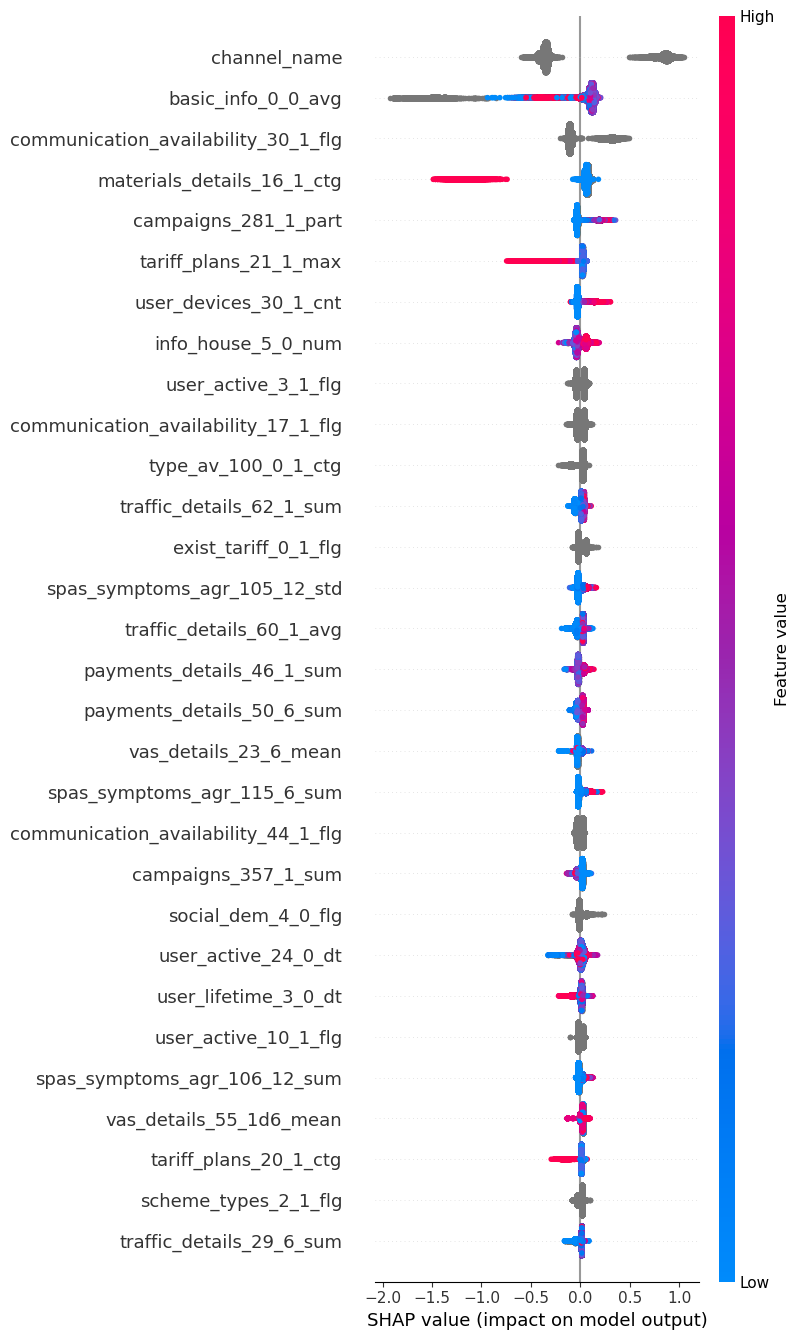

In [80]:
# Отобразим гистограмму важности признаков
import shap
shap_test = shap.TreeExplainer(model_cat_down5).shap_values(features_downsampled_train)
shap.summary_plot(shap_test, features_downsampled_train,
                      max_display=30, auto_size_plot=True)

In [81]:
# Сделам таблицу признаков
features = features_downsampled_train
X_importance = features_downsampled_train

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model_cat_down5)
shap_values = explainer.shap_values(X_importance)

vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(features.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(90)

TypeError: 'numpy.float64' object is not iterable

In [83]:
# Получите важности признаков
feature_importance = model_cat_down5.get_feature_importance()

# Создайте DataFrame с названиями признаков и их важностями
importance_df = pd.DataFrame({'feature': features_downsampled_train.columns, 'importance': feature_importance})

# Отсортируйте по убыванию важности
importance_df = importance_df.sort_values('importance', ascending=False)

# Выведите результаты
importance_df = importance_df.head(100).reset_index()
importance_df


,index,feature,importance
0,0,channel_name,14.507262
1,2,basic_info_0_0_avg,11.084682
2,12,materials_details_16_1_ctg,5.887887
3,524,communication_availability_30_1_flg,3.373614
4,781,tariff_plans_21_1_max,1.683888
...,...,...,...
95,536,user_lifetime_2_1_num,0.222416
96,498,traffic_details_44_1_sum,0.218193
97,18,communication_availability_69_1_flg,0.217357
98,817,spas_symptoms_agr_125_6_avg,0.215081


In [84]:
importance_df = importance_df.head(100)
feature_list = importance_df['feature'].to_list()
feature_list

['channel_name',
 'basic_info_0_0_avg',
 'materials_details_16_1_ctg',
 'communication_availability_30_1_flg',
 'tariff_plans_21_1_max',
 'payments_details_49_6_avg',
 'user_active_24_0_dt',
 'info_house_5_0_num',
 'user_devices_30_1_cnt',
 'tariff_plans_19_src_id',
 'campaigns_281_1_part',
 'user_lifetime_3_0_dt',
 'markers_912_1_cnt',
 'markers_905_1_cnt',
 'payments_details_45_1_avg',
 'payments_details_46_1_sum',
 'type_av_100_0_1_ctg',
 'tariff_plans_20_1_ctg',
 'traffic_details_34_1d6_avg',
 'traffic_details_60_1_avg',
 'campaigns_357_1_sum',
 'traffic_details_59_6_sum',
 'info_house_6_0_num',
 'plan_costs_0_1_sum',
 'markers_904_1_cnt',
 'traffic_details_50_6_sum',
 'exist_tariff_0_1_flg',
 'communication_availability_17_1_flg',
 'cities_2_0_ctg',
 'campaigns_403_3d6_part',
 'traffic_details_35_1d6_std',
 'markers_933_1_cnt',
 'traffic_details_62_1_sum',
 'traffic_details_9_3d6_part',
 'traffic_details_33_1d3_std',
 'communication_availability_40_1_ctg',
 'scheme_types_2_1_flg',

In [86]:
nick = ['tariff_plans_4_1_num',
 'charges_details_12_1_sum',
 'payments_details_35_6_sum',
 'spas_symptoms_agr_7_6_sum',
 'markers_706_1_cnt',
 'payments_details_28_3_sumpct',
 'payments_details_27_1_sumpct',
 'payments_details_29_6_sumpct',
 'balance_details_0_1_num',
 'payments_details_49_6_avg',
 'payments_details_48_3_sum',
 'markers_346_1_cnt',
 'spas_symptoms_agr_18_6_std',
 'arpu_2_6_avg',
 'markers_349_1_cnt',
 'markers_323_1_cnt',
 'markers_476_1_cnt',
 'payments_details_23_3d6_avg',
 'markers_40_1_cnt',
 'markers_310_1_cnt',
 'markers_60_1_cnt',
 'markers_330_1_cnt',
 'markers_333_1_cnt',
 'payments_details_33_1_sum',
 'markers_334_1_cnt',
 'markers_772_1_cnt',
 'markers_59_1_cnt',
 'markers_242_1_cnt',
 'markers_387_1_cnt',
 'tariff_plans_5_1_num']

In [87]:
features_all  = feature_list + ['channel_name','target'] + nick

In [88]:
len(features_all)

132

In [89]:
# Загрузим признаки
data_all = pd.read_parquet('dataset_train.parquet', engine='fastparquet', columns=features_all)

In [90]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 129 entries, channel_name to tariff_plans_5_1_num
dtypes: float64(110), int32(14), int64(3), int8(1), object(1)
memory usage: 648.8+ MB


In [91]:
# Marking cat_features
cat = ['ctg', 'flg','channel_name','src_id']
cat_features = cat_columns(data_all, cat)
data_all[cat_features] = data_all[cat_features].astype('category')
data_all['materials_details_16_1_ctg'] = data_all['materials_details_16_1_ctg'].astype('float64')
data_all['tariff_plans_20_1_ctg'] = data_all['tariff_plans_20_1_ctg'].astype('float64')

In [95]:
# Выделим выборку
features = data_all.drop(['target'], axis=1)
target = data_all['target']


In [96]:
# Make downsampling
features_downsampled, target_downsampled = downsample(features, target, 0.2)


In [97]:
features_upsampled, target_upsampled = upsample(features_downsampled, target_downsampled, 4)

In [104]:
target_upsampled.value_counts()

0    139323
1     21876
Name: target, dtype: int64

In [105]:
# Make train and test samples
features_downsampled_train, features_downsampled_test, target_downsampled_train,target_downsampled_test = train_test_split(features_downsampled, target_downsampled, test_size=0.25, random_state=RANDOM_STATE)

In [106]:
print(features_downsampled_train.shape)
print(target_downsampled_train.shape)
print(features_downsampled_test.shape)
print(target_downsampled_test.shape)

(108594, 128)
(108594,)
(36198, 128)
(36198,)


In [107]:
features_downsampled_train['materials_details_16_1_ctg'] = features_downsampled_train['materials_details_16_1_ctg'].astype('float64')
features_downsampled_train['tariff_plans_20_1_ctg'] = features_downsampled_train['tariff_plans_20_1_ctg'].astype('float64')
features_downsampled_test['materials_details_16_1_ctg'] = features_downsampled_test['materials_details_16_1_ctg'].astype('float64')
features_downsampled_test['tariff_plans_20_1_ctg'] = features_downsampled_test['tariff_plans_20_1_ctg'].astype('float64')

In [113]:
%time
cat_features = features_downsampled_train.select_dtypes(include='category').columns.to_list()
# Построим модель CatBoostClassifier

model_cat_down5 = CatBoostClassifier(loss_function="Logloss", verbose=10,\
                               
                               eval_metric='AUC:hints=skip_train~false',\
                                      cat_features=cat_features,\
                               random_state=RANDOM_STATE, auto_class_weights="Balanced") 

grid = {'learning_rate': [0.05, 0.1, 0.3],
        'depth': [2, 6, 8],
        'l2_leaf_reg': [3, 8],
        'iterations': [200] }
grid_search_result = model_cat_down5.grid_search(grid,
                                       X=features_downsampled_train, 
                                       y=target_downsampled_train,
                                       plot=True, cv=5)

CPU times: total: 0 ns
Wall time: 0 ns


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6793472	test: 0.6805506	best: 0.6805506 (0)	total: 106ms	remaining: 21.1s
10:	learn: 0.7218366	test: 0.7256433	best: 0.7268191 (7)	total: 1.43s	remaining: 24.6s
20:	learn: 0.7349648	test: 0.7366654	best: 0.7366654 (20)	total: 2.64s	remaining: 22.5s
30:	learn: 0.7387661	test: 0.7402589	best: 0.7402589 (30)	total: 4.15s	remaining: 22.6s
40:	learn: 0.7425544	test: 0.7438318	best: 0.7438318 (40)	total: 5.88s	remaining: 22.8s
50:	learn: 0.7463612	test: 0.7465146	best: 0.7465146 (50)	total: 7.62s	remaining: 22.3s
60:	learn: 0.7491998	test: 0.7495946	best: 0.7495946 (60)	total: 9.11s	remaining: 20.8s
70:	learn: 0.7515527	test: 0.7514636	best: 0.7514636 (70)	total: 10.7s	remaining: 19.5s
80:	learn: 0.7531209	test: 0.7528056	best: 0.7528056 (80)	total: 12.4s	remaining: 18.2s
90:	learn: 0.7547090	test: 0.7542282	best: 0.7542282 (90)	total: 14s	remaining: 16.8s
100:	learn: 0.7557197	test: 0.7550781	best: 0.7550781 (100)	total: 15.7s	remaining: 15.4s
110:	learn: 0.7571278	test: 0.75632

In [114]:
probabilities_cat = model_cat_down5.predict_proba(features_downsampled_test)[:,1]
auc_roc = roc_auc_score(target_downsampled_test, probabilities_cat)

print('Метрика ROC_AUC на тестовой выборке:', auc_roc)

Метрика ROC_AUC на тестовой выборке: 0.7479618423587374


In [115]:
probabilities_cat = model_cat_down5.predict(features_downsampled_test)
auc_roc = roc_auc_score(target_downsampled_test, probabilities_cat)

print('Метрика ROC_AUC на тестовой выборке:', auc_roc)

Метрика ROC_AUC на тестовой выборке: 0.6815899512456041


In [111]:
# Make downsampling
features_, target_ = downsample(features, target, 0.2)
features_, features_test, target_,target_test = train_test_split(features_, target_, test_size=0.25, random_state=RANDOM_STATE)

In [112]:
probabilities_cat = model_cat_down5.predict(features_test)
auc_roc = roc_auc_score(target_test, probabilities_cat)

print('Метрика ROC_AUC на тестовой выборке:', auc_roc)


Метрика ROC_AUC на тестовой выборке: 0.6773550663379485


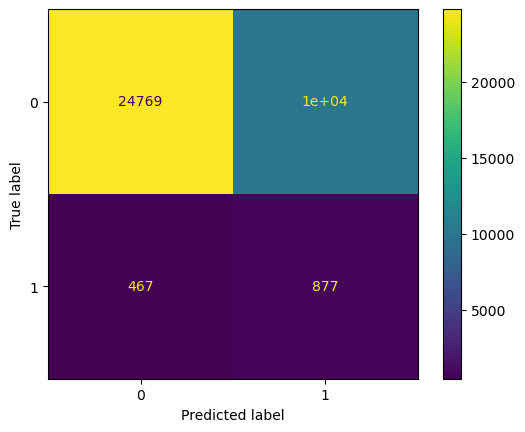

In [116]:
# Матрица ошибок
predicted_cat = model_cat_down5.predict(features_downsampled_test)

cm = confusion_matrix(target_downsampled_test, predicted_cat, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

plt.show()

In [139]:
# Загрузим признаки
features_all  = feature_list + ['channel_name', 'id'] + nick
data_test = pd.read_parquet('features_oot.parquet', engine='fastparquet', columns=features_all)

In [141]:
# Выделим фичи и таргет
# Marking cat_features

# Marking cat_features

cat_features = cat_columns(data_test, cat)
data_test[cat_features] = data_test[cat_features].astype('category')
data_test['materials_details_16_1_ctg'] = data_test['materials_details_16_1_ctg'].astype('float64')
data_test['tariff_plans_20_1_ctg'] = data_test['tariff_plans_20_1_ctg'].astype('float64')
features = data_test.drop(['id'], axis=1)

In [142]:
test_data = data_test['id']
test_data = test_data.reset_index()

In [144]:
probabilities_cat = model_cat_down5.predict_proba(features)

In [145]:
target_test = probabilities_cat[:,1]
target_test = pd.Series(target_test)

In [146]:
test_data = pd.concat([test_data, target_test], axis=1)

In [147]:
test_data

,index,id,0
0,0,1548227,0.655895
1,1,1173554,0.560972
2,2,1370450,0.439090
3,3,1254949,0.406561
4,4,1549365,0.685812
...,...,...,...
60656,60656,1510674,0.718302
60657,60657,1106063,0.726504
60658,60658,1396317,0.810502
60659,60659,1447072,0.902977


In [148]:
test_data = test_data.drop(['id'], axis=1)
test_data.columns = ['id', 'target']
test_data

,id,target
0,0,0.655895
1,1,0.560972
2,2,0.439090
3,3,0.406561
4,4,0.685812
...,...,...
60656,60656,0.718302
60657,60657,0.726504
60658,60658,0.810502
60659,60659,0.902977


In [149]:
test_data.to_csv('test_data_13.csv', index=False)